In [5]:
from SRCNN_different_specs import RunSRCNN, SRCNN
from custom_image_dataset import CustomImageDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
from torch import nn
import numpy as np
import image_patches

In [ ]:
PREFIX = 'UNFILTERED'

TRAIN_DATASET_NAME = "./datasets/TRAIN_Flick2k_DIV2K/"
VALIDATION_DATASET_NAME = "./datasets/VALIDATION_Flickr2K_DIV2K/"
# TRAIN_DATASET_NAME = "../datasets/set14/"
# VALIDATION_DATASET_NAME = "../datasets/Set5/"
PATCH_SIZE = 33

SCALE_FACTOR = 4

EPOCHS = 150

PATCHES_PER_IMAGE_TRAIN = 40 #####
# PATCHES_PER_IMAGE_TRAIN = 10
PATCHES_PER_IMAGE_VALIDATION = 40 #####
# PATCHES_PER_IMAGE_VALIDATION = 3 
TRAIN_DATA_PATH = f"{TRAIN_DATASET_NAME}_{PREFIX}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_TRAIN}"
VALIDATION_DATA_PATH =  f"{VALIDATION_DATASET_NAME}_{PREFIX}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_VALIDATION}"
print('TRAIN_DATA_PATH =', TRAIN_DATA_PATH)
print('VALIDATION_DATA_PATH =', VALIDATION_DATA_PATH)

TRAIN_DATA_PATH = ./datasets/TRAIN_Flick2k_DIV2K/_UNFILTERED_33_33_number=40
VALIDATION_DATA_PATH = ./datasets/VALIDATION_Flickr2K_DIV2K/_UNFILTERED_33_33_number=40


In [3]:
# image_patches.create_image_patches(f"{TRAIN_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), TRAIN_DATA_PATH, PATCHES_PER_IMAGE_TRAIN)
# image_patches.create_image_patches(f"{VALIDATION_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), VALIDATION_DATA_PATH, PATCHES_PER_IMAGE_VALIDATION)

In [4]:
EPOCHS = 150

In [5]:
%%time
transform_x = transforms.Compose([
    transforms.Resize((PATCH_SIZE // SCALE_FACTOR, PATCH_SIZE // SCALE_FACTOR), interpolation=Image.BICUBIC),
    transforms.Resize((PATCH_SIZE, PATCH_SIZE), interpolation=Image.BICUBIC)
])

transform_y = transforms.Compose([
    transforms.CenterCrop((PATCH_SIZE, PATCH_SIZE))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=TRAIN_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)
validation_data_set = CustomImageDataset(
    img_dir=VALIDATION_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Creating Dataset based on folder: ./datasets/TRAIN_Flick2k_DIV2K/_UNFILTERED_33_33_number=40


100%|██████████| 2920/2920 [00:14<00:00, 201.42it/s]


Creating Dataset based on folder: ./datasets/TRAIN_Flick2k_DIV2K/_UNFILTERED_33_33_number=40
Creating Dataset based on folder: ./datasets/VALIDATION_Flickr2K_DIV2K/_UNFILTERED_33_33_number=40


100%|██████████| 630/630 [00:03<00:00, 204.04it/s]


Creating Dataset based on folder: ./datasets/VALIDATION_Flickr2K_DIV2K/_UNFILTERED_33_33_number=40
Training set has 116800 instances
Validation set has 25200 instances
CPU times: user 17.3 s, sys: 3.9 s, total: 21.2 s
Wall time: 21.2 s


In [6]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(1*(2**13))

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory) # TODO: aumentar batch_size p/ 2^12
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: user 1.56 s, sys: 420 ms, total: 1.98 s
Wall time: 1.98 s


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 1e-3

model_f2_5 = SRCNN(f2=5).to(device)
optimizer_f2_5 = torch.optim.Adam(model_f2_5.parameters(), lr=lr)
scheduler_f2_5 = torch.optim.lr_scheduler.LinearLR(
    optimizer_f2_5,
    start_factor=1.0,
    end_factor=0.01,
    total_iters=60)

model_f2_1 = SRCNN(f2=1).to(device)
optimizer_f2_1 = torch.optim.Adam(model_f2_1.parameters(), lr=lr)
scheduler_f2_1 = torch.optim.lr_scheduler.LinearLR(
    optimizer_f2_1,
    start_factor=1.0,
    end_factor=0.01,
    total_iters=60)


In [8]:
run_srcnn = RunSRCNN()

In [12]:
%%time
run_srcnn.train(
    model=model_f2_1,
    train_dataloader=train_dataloader,
    validation_dataloader=validation_dataloader,
    optimizer=optimizer_f2_1,
    epochs=EPOCHS,
    scheduler=scheduler_f2_1,
    loss_fn=nn.MSELoss(),
)


epoch 0
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


  0%|          | 0/15 [00:00<?, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.091523 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.044878 

Learning rate (antes): 0.001
Learning rate (depois): 0.0009835

epoch 1
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.039490 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.030472 

Learning rate (antes): 0.0009835
Learning rate (depois): 0.000967

epoch 2
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.025697 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.019004 

Learning rate (antes): 0.000967
Learning rate (depois): 0.0009505

epoch 3
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.016251 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.012839 

Learning rate (antes): 0.0009505
Learning rate (depois): 0.0009339999999999999

epoch 4
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.012640 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.011019 

Learning rate (antes): 0.0009339999999999999
Learning rate (depois): 0.0009174999999999999

epoch 5
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


Training Error: 
 Avg loss: 0.011286 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.010098 

Learning rate (antes): 0.0009174999999999999
Learning rate (depois): 0.0009009999999999999

epoch 6
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.010463 



100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Validation Error: 
 Avg loss: 0.009445 

Learning rate (antes): 0.0009009999999999999
Learning rate (depois): 0.0008844999999999999

epoch 7
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


Training Error: 
 Avg loss: 0.009817 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.008831 

Learning rate (antes): 0.0008844999999999999
Learning rate (depois): 0.0008679999999999998

epoch 8
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.009223 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.008367 

Learning rate (antes): 0.0008679999999999998
Learning rate (depois): 0.0008514999999999998

epoch 9
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.008767 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.008115 

Learning rate (antes): 0.0008514999999999998
Learning rate (depois): 0.0008349999999999998

epoch 10
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.008460 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.007642 

Learning rate (antes): 0.0008349999999999998
Learning rate (depois): 0.0008184999999999998

epoch 11
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.008093 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.007373 

Learning rate (antes): 0.0008184999999999998
Learning rate (depois): 0.0008019999999999998

epoch 12
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.007872 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.007186 

Learning rate (antes): 0.0008019999999999998
Learning rate (depois): 0.0007854999999999997

epoch 13
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.007744 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.007108 

Learning rate (antes): 0.0007854999999999997
Learning rate (depois): 0.0007689999999999997

epoch 14
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.007605 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.006967 

Learning rate (antes): 0.0007689999999999997
Learning rate (depois): 0.0007524999999999997

epoch 15
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.007450 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.006835 

Learning rate (antes): 0.0007524999999999997
Learning rate (depois): 0.0007359999999999997

epoch 16
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.007339 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.006725 

Learning rate (antes): 0.0007359999999999997
Learning rate (depois): 0.0007194999999999997

epoch 17
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.007241 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.006661 

Learning rate (antes): 0.0007194999999999997
Learning rate (depois): 0.0007029999999999996

epoch 18
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.007146 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.006542 

Learning rate (antes): 0.0007029999999999996
Learning rate (depois): 0.0006864999999999997

epoch 19
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.007066 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.006495 

Learning rate (antes): 0.0006864999999999997
Learning rate (depois): 0.0006699999999999997

epoch 20
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.007009 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.006390 

Learning rate (antes): 0.0006699999999999997
Learning rate (depois): 0.0006534999999999998

epoch 21
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.006905 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.006316 

Learning rate (antes): 0.0006534999999999998
Learning rate (depois): 0.0006369999999999998

epoch 22
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.006825 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.006271 

Learning rate (antes): 0.0006369999999999998
Learning rate (depois): 0.0006204999999999997

epoch 23
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.006757 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.006199 

Learning rate (antes): 0.0006204999999999997
Learning rate (depois): 0.0006039999999999997

epoch 24
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.006689 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.006141 

Learning rate (antes): 0.0006039999999999997
Learning rate (depois): 0.0005874999999999997

epoch 25
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.006622 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.006078 

Learning rate (antes): 0.0005874999999999997
Learning rate (depois): 0.0005709999999999998

epoch 26
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.006601 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.006061 

Learning rate (antes): 0.0005709999999999998
Learning rate (depois): 0.0005544999999999998

epoch 27
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.006527 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005979 

Learning rate (antes): 0.0005544999999999998
Learning rate (depois): 0.0005379999999999997

epoch 28
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.006474 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005927 

Learning rate (antes): 0.0005379999999999997
Learning rate (depois): 0.0005214999999999997

epoch 29
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.006435 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005884 

Learning rate (antes): 0.0005214999999999997
Learning rate (depois): 0.0005049999999999997

epoch 30
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.006385 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.005846 

Learning rate (antes): 0.0005049999999999997
Learning rate (depois): 0.0004884999999999997

epoch 31
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.006327 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005816 

Learning rate (antes): 0.0004884999999999997
Learning rate (depois): 0.0004719999999999997

epoch 32
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.006300 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005779 

Learning rate (antes): 0.0004719999999999997
Learning rate (depois): 0.00045549999999999974

epoch 33
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.006257 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.005738 

Learning rate (antes): 0.00045549999999999974
Learning rate (depois): 0.0004389999999999998

epoch 34
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.006236 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005712 

Learning rate (antes): 0.0004389999999999998
Learning rate (depois): 0.00042249999999999975

epoch 35
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.006188 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005681 

Learning rate (antes): 0.00042249999999999975
Learning rate (depois): 0.0004059999999999998

epoch 36
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.006175 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.005655 

Learning rate (antes): 0.0004059999999999998
Learning rate (depois): 0.0003894999999999998

epoch 37
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.006135 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005633 

Learning rate (antes): 0.0003894999999999998
Learning rate (depois): 0.00037299999999999985

epoch 38
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.006119 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005610 

Learning rate (antes): 0.00037299999999999985
Learning rate (depois): 0.00035649999999999983

epoch 39
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.006108 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.005586 

Learning rate (antes): 0.00035649999999999983
Learning rate (depois): 0.0003399999999999998

epoch 40
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.006090 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005568 

Learning rate (antes): 0.0003399999999999998
Learning rate (depois): 0.0003234999999999998

epoch 41
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.006076 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005546 

Learning rate (antes): 0.0003234999999999998
Learning rate (depois): 0.00030699999999999976

epoch 42
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.006055 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.005530 

Learning rate (antes): 0.00030699999999999976
Learning rate (depois): 0.00029049999999999974

epoch 43
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.006024 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005513 

Learning rate (antes): 0.00029049999999999974
Learning rate (depois): 0.0002739999999999998

epoch 44
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.006005 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.005496 

Learning rate (antes): 0.0002739999999999998
Learning rate (depois): 0.0002574999999999998

epoch 45
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005996 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.005481 

Learning rate (antes): 0.0002574999999999998
Learning rate (depois): 0.0002409999999999998

epoch 46
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


Training Error: 
 Avg loss: 0.005964 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005467 

Learning rate (antes): 0.0002409999999999998
Learning rate (depois): 0.00022449999999999982

epoch 47
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005952 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005454 

Learning rate (antes): 0.00022449999999999982
Learning rate (depois): 0.00020799999999999982

epoch 48
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005922 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005442 

Learning rate (antes): 0.00020799999999999982
Learning rate (depois): 0.00019149999999999986

epoch 49
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005933 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005432 

Learning rate (antes): 0.00019149999999999986
Learning rate (depois): 0.00017499999999999986

epoch 50
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005929 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005422 

Learning rate (antes): 0.00017499999999999986
Learning rate (depois): 0.00015849999999999987

epoch 51
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005908 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005413 

Learning rate (antes): 0.00015849999999999987
Learning rate (depois): 0.00014199999999999987

epoch 52
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005903 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005404 

Learning rate (antes): 0.00014199999999999987
Learning rate (depois): 0.0001254999999999999

epoch 53
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005883 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005397 

Learning rate (antes): 0.0001254999999999999
Learning rate (depois): 0.00010899999999999993

epoch 54
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005888 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005391 

Learning rate (antes): 0.00010899999999999993
Learning rate (depois): 9.249999999999994e-05

epoch 55
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005888 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005386 

Learning rate (antes): 9.249999999999994e-05
Learning rate (depois): 7.599999999999995e-05

epoch 56
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005892 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005382 

Learning rate (antes): 7.599999999999995e-05
Learning rate (depois): 5.949999999999996e-05

epoch 57
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005866 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005378 

Learning rate (antes): 5.949999999999996e-05
Learning rate (depois): 4.299999999999998e-05

epoch 58
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005870 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005375 

Learning rate (antes): 4.299999999999998e-05
Learning rate (depois): 2.6499999999999977e-05

epoch 59
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005872 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005374 

Learning rate (antes): 2.6499999999999977e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 60
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005855 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005373 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 61
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005863 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005372 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 62
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005864 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005372 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 63
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005863 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005371 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 64
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005852 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005371 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 65
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005863 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005370 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 66
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005870 



100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Validation Error: 
 Avg loss: 0.005369 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 67
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005861 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005369 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 68
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005868 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005368 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 69
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005867 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005367 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 70
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005861 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005367 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 71
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005860 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005366 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 72
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005872 



100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Validation Error: 
 Avg loss: 0.005365 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 73
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005846 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005365 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 74
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005865 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005364 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 75
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005854 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005363 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 76
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005848 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005363 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 77
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005859 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005362 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 78
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005850 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005361 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 79
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005863 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005360 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 80
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005859 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005360 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 81
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005843 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005359 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 82
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005862 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005358 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 83
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005849 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005358 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 84
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005856 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005357 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 85
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005873 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005356 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 86
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005851 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005355 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 87
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005844 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005354 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 88
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005865 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005354 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 89
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005845 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.005353 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 90
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005851 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005352 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 91
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005856 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005351 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 92
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005824 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005350 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 93
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005825 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005350 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 94
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005836 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005349 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 95
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005835 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005348 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 96
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005831 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005347 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 97
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005835 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.005346 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 98
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005833 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005346 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 99
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


Training Error: 
 Avg loss: 0.005842 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005345 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 100
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005848 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005344 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 101
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005810 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005343 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 102
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005826 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005342 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 103
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005831 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005341 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 104
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005832 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005340 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 105
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005824 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005340 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 106
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005828 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005339 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 107
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005844 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005338 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 108
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005828 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005337 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 109
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005833 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005336 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 110
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005810 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005335 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 111
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005833 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005334 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 112
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005819 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005333 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 113
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005826 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005332 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 114
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005823 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005331 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 115
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005820 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005330 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 116
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005809 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005330 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 117
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005829 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005329 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 118
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005829 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005328 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 119
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005833 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005327 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 120
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005824 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005326 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 121
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005830 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005325 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 122
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005820 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005324 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 123
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005822 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005323 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 124
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005814 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005322 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 125
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005810 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005321 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 126
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005811 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005320 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 127
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005816 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005319 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 128
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005803 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005318 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 129
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005797 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005317 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 130
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005811 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005316 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 131
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005808 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005315 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 132
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Training Error: 
 Avg loss: 0.005798 



100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Validation Error: 
 Avg loss: 0.005314 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 133
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005819 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005313 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 134
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005802 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005312 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 135
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Training Error: 
 Avg loss: 0.005803 



100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Validation Error: 
 Avg loss: 0.005310 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 136
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005817 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005309 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 137
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005803 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005308 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 138
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Training Error: 
 Avg loss: 0.005774 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005307 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 139
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005813 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005306 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 140
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005807 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005305 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 141
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005793 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005304 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 142
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005802 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005303 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 143
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005805 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005302 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 144
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Training Error: 
 Avg loss: 0.005794 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.005301 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 145
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005795 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.005300 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 146
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Training Error: 
 Avg loss: 0.005792 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.005298 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 147
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.005782 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005297 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 148
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Training Error: 
 Avg loss: 0.005797 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.005296 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 149
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.005788 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]

Validation Error: 
 Avg loss: 0.005295 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05
CPU times: user 1h 55min 15s, sys: 3min 49s, total: 1h 59min 4s
Wall time: 1h 57min 11s


In [13]:
df_f2_1 = run_srcnn.get_model_df()
df_f2_1.tail()

,epoch,time,lr,train_loss,validation_loss
145,145,46.966396,0.00001,0.005795,0.005300
146,146,46.499086,0.00001,0.005792,0.005298
147,147,47.208977,0.00001,0.005782,0.005297
148,148,47.008946,0.00001,0.005797,0.005296
149,149,46.576148,0.00001,0.005788,0.005295


In [14]:
# run_srcnn.save_model_df('./results/srcnn-tecgraf/dataframes/model_f2_1_unfiltered.csv')
# run_srcnn.save_model_weights(model_f2_1, './results/srcnn-tecgraf/trained_weights/model_f2_1_unfiltered.pth')

In [9]:
%%time

run_srcnn.clear_all()

run_srcnn.train(
    model=model_f2_5,
    train_dataloader=train_dataloader,
    validation_dataloader=validation_dataloader,
    optimizer=optimizer_f2_5,
    epochs=EPOCHS,
    scheduler=scheduler_f2_5,
    loss_fn=nn.MSELoss(),
)


epoch 0
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


  0%|          | 0/15 [00:00<?, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


Training Error: 
 Avg loss: 0.064515 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.025493 

Learning rate (antes): 0.001
Learning rate (depois): 0.0009835

epoch 1
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


Training Error: 
 Avg loss: 0.017312 



100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Validation Error: 
 Avg loss: 0.011362 

Learning rate (antes): 0.0009835
Learning rate (depois): 0.000967

epoch 2
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


Training Error: 
 Avg loss: 0.010323 



100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Validation Error: 
 Avg loss: 0.008250 

Learning rate (antes): 0.000967
Learning rate (depois): 0.0009505

epoch 3
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.53s/it]


Training Error: 
 Avg loss: 0.008103 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.006961 

Learning rate (antes): 0.0009505
Learning rate (depois): 0.0009339999999999999

epoch 4
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


Training Error: 
 Avg loss: 0.007036 



100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


Validation Error: 
 Avg loss: 0.006119 

Learning rate (antes): 0.0009339999999999999
Learning rate (depois): 0.0009174999999999999

epoch 5
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


Training Error: 
 Avg loss: 0.006331 



100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Validation Error: 
 Avg loss: 0.005576 

Learning rate (antes): 0.0009174999999999999
Learning rate (depois): 0.0009009999999999999

epoch 6
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.53s/it]


Training Error: 
 Avg loss: 0.005932 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.005298 

Learning rate (antes): 0.0009009999999999999
Learning rate (depois): 0.0008844999999999999

epoch 7
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


Training Error: 
 Avg loss: 0.005713 



100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


Validation Error: 
 Avg loss: 0.005131 

Learning rate (antes): 0.0008844999999999999
Learning rate (depois): 0.0008679999999999998

epoch 8
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


Training Error: 
 Avg loss: 0.005559 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.005026 

Learning rate (antes): 0.0008679999999999998
Learning rate (depois): 0.0008514999999999998

epoch 9
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


Training Error: 
 Avg loss: 0.005444 



100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Validation Error: 
 Avg loss: 0.004951 

Learning rate (antes): 0.0008514999999999998
Learning rate (depois): 0.0008349999999999998

epoch 10
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.005404 



100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Validation Error: 
 Avg loss: 0.004894 

Learning rate (antes): 0.0008349999999999998
Learning rate (depois): 0.0008184999999999998

epoch 11
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


Training Error: 
 Avg loss: 0.005349 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004844 

Learning rate (antes): 0.0008184999999999998
Learning rate (depois): 0.0008019999999999998

epoch 12
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Training Error: 
 Avg loss: 0.005295 



100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Validation Error: 
 Avg loss: 0.004804 

Learning rate (antes): 0.0008019999999999998
Learning rate (depois): 0.0007854999999999997

epoch 13
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.005265 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004769 

Learning rate (antes): 0.0007854999999999997
Learning rate (depois): 0.0007689999999999997

epoch 14
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.005236 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004741 

Learning rate (antes): 0.0007689999999999997
Learning rate (depois): 0.0007524999999999997

epoch 15
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.005190 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004723 

Learning rate (antes): 0.0007524999999999997
Learning rate (depois): 0.0007359999999999997

epoch 16
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.005153 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004691 

Learning rate (antes): 0.0007359999999999997
Learning rate (depois): 0.0007194999999999997

epoch 17
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Training Error: 
 Avg loss: 0.005147 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004675 

Learning rate (antes): 0.0007194999999999997
Learning rate (depois): 0.0007029999999999996

epoch 18
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


Training Error: 
 Avg loss: 0.005143 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.004656 

Learning rate (antes): 0.0007029999999999996
Learning rate (depois): 0.0006864999999999997

epoch 19
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.005107 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004641 

Learning rate (antes): 0.0006864999999999997
Learning rate (depois): 0.0006699999999999997

epoch 20
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Training Error: 
 Avg loss: 0.005100 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004631 

Learning rate (antes): 0.0006699999999999997
Learning rate (depois): 0.0006534999999999998

epoch 21
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.005076 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004612 

Learning rate (antes): 0.0006534999999999998
Learning rate (depois): 0.0006369999999999998

epoch 22
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.005074 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004604 

Learning rate (antes): 0.0006369999999999998
Learning rate (depois): 0.0006204999999999997

epoch 23
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Training Error: 
 Avg loss: 0.005062 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004590 

Learning rate (antes): 0.0006204999999999997
Learning rate (depois): 0.0006039999999999997

epoch 24
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.005074 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004580 

Learning rate (antes): 0.0006039999999999997
Learning rate (depois): 0.0005874999999999997

epoch 25
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.005034 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004572 

Learning rate (antes): 0.0005874999999999997
Learning rate (depois): 0.0005709999999999998

epoch 26
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.005021 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004563 

Learning rate (antes): 0.0005709999999999998
Learning rate (depois): 0.0005544999999999998

epoch 27
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.005019 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004554 

Learning rate (antes): 0.0005544999999999998
Learning rate (depois): 0.0005379999999999997

epoch 28
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.005009 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004546 

Learning rate (antes): 0.0005379999999999997
Learning rate (depois): 0.0005214999999999997

epoch 29
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004991 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004539 

Learning rate (antes): 0.0005214999999999997
Learning rate (depois): 0.0005049999999999997

epoch 30
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004997 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004533 

Learning rate (antes): 0.0005049999999999997
Learning rate (depois): 0.0004884999999999997

epoch 31
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004974 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004526 

Learning rate (antes): 0.0004884999999999997
Learning rate (depois): 0.0004719999999999997

epoch 32
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004990 



100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Validation Error: 
 Avg loss: 0.004520 

Learning rate (antes): 0.0004719999999999997
Learning rate (depois): 0.00045549999999999974

epoch 33
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Training Error: 
 Avg loss: 0.004956 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004513 

Learning rate (antes): 0.00045549999999999974
Learning rate (depois): 0.0004389999999999998

epoch 34
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004969 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004509 

Learning rate (antes): 0.0004389999999999998
Learning rate (depois): 0.00042249999999999975

epoch 35
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004974 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004504 

Learning rate (antes): 0.00042249999999999975
Learning rate (depois): 0.0004059999999999998

epoch 36
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Training Error: 
 Avg loss: 0.004947 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004499 

Learning rate (antes): 0.0004059999999999998
Learning rate (depois): 0.0003894999999999998

epoch 37
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004952 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004494 

Learning rate (antes): 0.0003894999999999998
Learning rate (depois): 0.00037299999999999985

epoch 38
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004952 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004490 

Learning rate (antes): 0.00037299999999999985
Learning rate (depois): 0.00035649999999999983

epoch 39
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Training Error: 
 Avg loss: 0.004959 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004493 

Learning rate (antes): 0.00035649999999999983
Learning rate (depois): 0.0003399999999999998

epoch 40
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004925 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004484 

Learning rate (antes): 0.0003399999999999998
Learning rate (depois): 0.0003234999999999998

epoch 41
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004925 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004478 

Learning rate (antes): 0.0003234999999999998
Learning rate (depois): 0.00030699999999999976

epoch 42
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004931 



100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Validation Error: 
 Avg loss: 0.004474 

Learning rate (antes): 0.00030699999999999976
Learning rate (depois): 0.00029049999999999974

epoch 43
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004922 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004471 

Learning rate (antes): 0.00029049999999999974
Learning rate (depois): 0.0002739999999999998

epoch 44
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Training Error: 
 Avg loss: 0.004932 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004464 

Learning rate (antes): 0.0002739999999999998
Learning rate (depois): 0.0002574999999999998

epoch 45
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004906 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004460 

Learning rate (antes): 0.0002574999999999998
Learning rate (depois): 0.0002409999999999998

epoch 46
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Training Error: 
 Avg loss: 0.004901 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004455 

Learning rate (antes): 0.0002409999999999998
Learning rate (depois): 0.00022449999999999982

epoch 47
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004906 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004452 

Learning rate (antes): 0.00022449999999999982
Learning rate (depois): 0.00020799999999999982

epoch 48
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004893 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004449 

Learning rate (antes): 0.00020799999999999982
Learning rate (depois): 0.00019149999999999986

epoch 49
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Training Error: 
 Avg loss: 0.004885 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004445 

Learning rate (antes): 0.00019149999999999986
Learning rate (depois): 0.00017499999999999986

epoch 50
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004902 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004442 

Learning rate (antes): 0.00017499999999999986
Learning rate (depois): 0.00015849999999999987

epoch 51
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004888 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004440 

Learning rate (antes): 0.00015849999999999987
Learning rate (depois): 0.00014199999999999987

epoch 52
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004887 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004437 

Learning rate (antes): 0.00014199999999999987
Learning rate (depois): 0.0001254999999999999

epoch 53
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004884 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004435 

Learning rate (antes): 0.0001254999999999999
Learning rate (depois): 0.00010899999999999993

epoch 54
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Training Error: 
 Avg loss: 0.004888 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004434 

Learning rate (antes): 0.00010899999999999993
Learning rate (depois): 9.249999999999994e-05

epoch 55
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004893 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004433 

Learning rate (antes): 9.249999999999994e-05
Learning rate (depois): 7.599999999999995e-05

epoch 56
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


Training Error: 
 Avg loss: 0.004878 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004431 

Learning rate (antes): 7.599999999999995e-05
Learning rate (depois): 5.949999999999996e-05

epoch 57
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004888 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004430 

Learning rate (antes): 5.949999999999996e-05
Learning rate (depois): 4.299999999999998e-05

epoch 58
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004882 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004429 

Learning rate (antes): 4.299999999999998e-05
Learning rate (depois): 2.6499999999999977e-05

epoch 59
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


Training Error: 
 Avg loss: 0.004873 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004429 

Learning rate (antes): 2.6499999999999977e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 60
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004886 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004429 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 61
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004880 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004429 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 62
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004871 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004429 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 63
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004884 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004428 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 64
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Training Error: 
 Avg loss: 0.004878 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004428 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 65
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004892 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004428 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 66
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004891 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004428 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 67
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004864 



100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Validation Error: 
 Avg loss: 0.004428 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 68
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004863 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004428 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 69
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004881 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004428 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 70
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004889 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004427 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 71
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004887 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004427 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 72
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004874 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004427 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 73
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004889 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004427 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 74
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004874 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004427 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 75
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004880 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004427 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 76
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004880 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004426 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 77
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004870 



100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Validation Error: 
 Avg loss: 0.004426 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 78
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004872 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004426 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 79
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Training Error: 
 Avg loss: 0.004879 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004426 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 80
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004867 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.004426 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 81
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004876 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004426 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 82
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004860 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004426 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 83
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004872 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.004425 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 84
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004884 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004425 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 85
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004864 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004425 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 86
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004858 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004425 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 87
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004878 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004425 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 88
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004883 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004425 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 89
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004875 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004424 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 90
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004864 



100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Validation Error: 
 Avg loss: 0.004424 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 91
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004885 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004424 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 92
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004866 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004424 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 93
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004850 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004424 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 94
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004877 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004424 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 95
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004881 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004423 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 96
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004849 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004423 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 97
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004850 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004423 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 98
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004882 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004423 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 99
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004877 



100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Validation Error: 
 Avg loss: 0.004423 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 100
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004868 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004422 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 101
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004881 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004422 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 102
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004866 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004422 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 103
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004872 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004422 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 104
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004871 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004422 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 105
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004863 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004422 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 106
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004878 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004421 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 107
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004875 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004421 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 108
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004875 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004421 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 109
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004863 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004421 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 110
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004878 



100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Validation Error: 
 Avg loss: 0.004421 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 111
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004859 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004420 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 112
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004866 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004420 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 113
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004881 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004420 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 114
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004855 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004420 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 115
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004857 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004420 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 116
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004873 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.004419 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 117
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004865 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004419 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 118
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004874 



100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Validation Error: 
 Avg loss: 0.004419 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 119
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004875 



100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Validation Error: 
 Avg loss: 0.004419 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 120
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004862 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004419 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 121
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004870 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004419 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 122
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004863 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004418 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 123
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004869 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004418 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 124
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004865 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004418 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 125
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004859 



100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Validation Error: 
 Avg loss: 0.004418 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 126
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004864 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004417 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 127
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004857 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.004417 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 128
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004876 



100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Validation Error: 
 Avg loss: 0.004417 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 129
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004866 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004417 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 130
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004859 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004417 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 131
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004866 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004416 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 132
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


Training Error: 
 Avg loss: 0.004867 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.004416 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 133
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004866 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004416 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 134
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004855 



100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Validation Error: 
 Avg loss: 0.004416 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 135
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004869 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004416 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 136
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004858 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004415 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 137
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


Training Error: 
 Avg loss: 0.004859 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004415 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 138
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Training Error: 
 Avg loss: 0.004851 



100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Validation Error: 
 Avg loss: 0.004415 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 139
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004868 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004415 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 140
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004865 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004415 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 141
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004858 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004414 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 142
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004865 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004414 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 143
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004841 



100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Validation Error: 
 Avg loss: 0.004414 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 144
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004869 



100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Validation Error: 
 Avg loss: 0.004414 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 145
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Training Error: 
 Avg loss: 0.004860 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004414 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 146
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Training Error: 
 Avg loss: 0.004860 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Validation Error: 
 Avg loss: 0.004413 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 147
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004861 



100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Validation Error: 
 Avg loss: 0.004413 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 148
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Training Error: 
 Avg loss: 0.004857 



100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Validation Error: 
 Avg loss: 0.004413 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 149
-------------------------------
Training on 116800 samples...
Batch size: 8192
Number of batches: 15


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Training Error: 
 Avg loss: 0.004850 



100%|██████████| 4/4 [00:07<00:00,  1.83s/it]

Validation Error: 
 Avg loss: 0.004413 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05
CPU times: user 1h 57min 13s, sys: 3min 50s, total: 2h 1min 3s
Wall time: 1h 59min 30s


In [10]:
df_f2_5 = run_srcnn.get_model_df()
df_f2_5.tail()

,epoch,time,lr,train_loss,validation_loss
145,145,47.944519,0.00001,0.004860,0.004414
146,146,47.456964,0.00001,0.004860,0.004413
147,147,47.830572,0.00001,0.004861,0.004413
148,148,47.770905,0.00001,0.004857,0.004413
149,149,47.477810,0.00001,0.004850,0.004413


In [11]:
# run_srcnn.save_model_df('./results/srcnn-tecgraf/dataframes/model_f2_5_unfiltered.csv')
# run_srcnn.save_model_weights(model_f2_5, './results/srcnn-tecgraf/trained_weights/model_f2_5_unfiltered.pth')

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_f2_1_test_unfiltered = SRCNN(f2=1).to(device)
model_f2_1_test_unfiltered.load_state_dict(torch.load('./results/srcnn-tecgraf/trained_weights/model_f2_1_unfiltered.pth', map_location=torch.device('cpu')))

model_f2_5_test_unfiltered = SRCNN(f2=5).to(device)
model_f2_5_test_unfiltered.load_state_dict(torch.load('./results/srcnn-tecgraf/trained_weights/model_f2_5_unfiltered.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:
path = f"./datasets/BSDS100/"
from model_runner import ModelRunner
model_runner = ModelRunner()
model_runner.compare_models([
                              {"name": "model_f2_1_test_unfiltered", "model": model_f2_1_test_unfiltered, "scale": 4}, 
                              {"name": "model_f2_5_test_unfiltered", "model": model_f2_5_test_unfiltered, "scale": 4},
                          ],
                            path, 4)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `P

,PSNR,SSIM
model_f2_1_test_unfiltered,23.262661,0.612962
model_f2_5_test_unfiltered,23.423830,0.619601
Bicubic,23.045410,0.632868


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the val

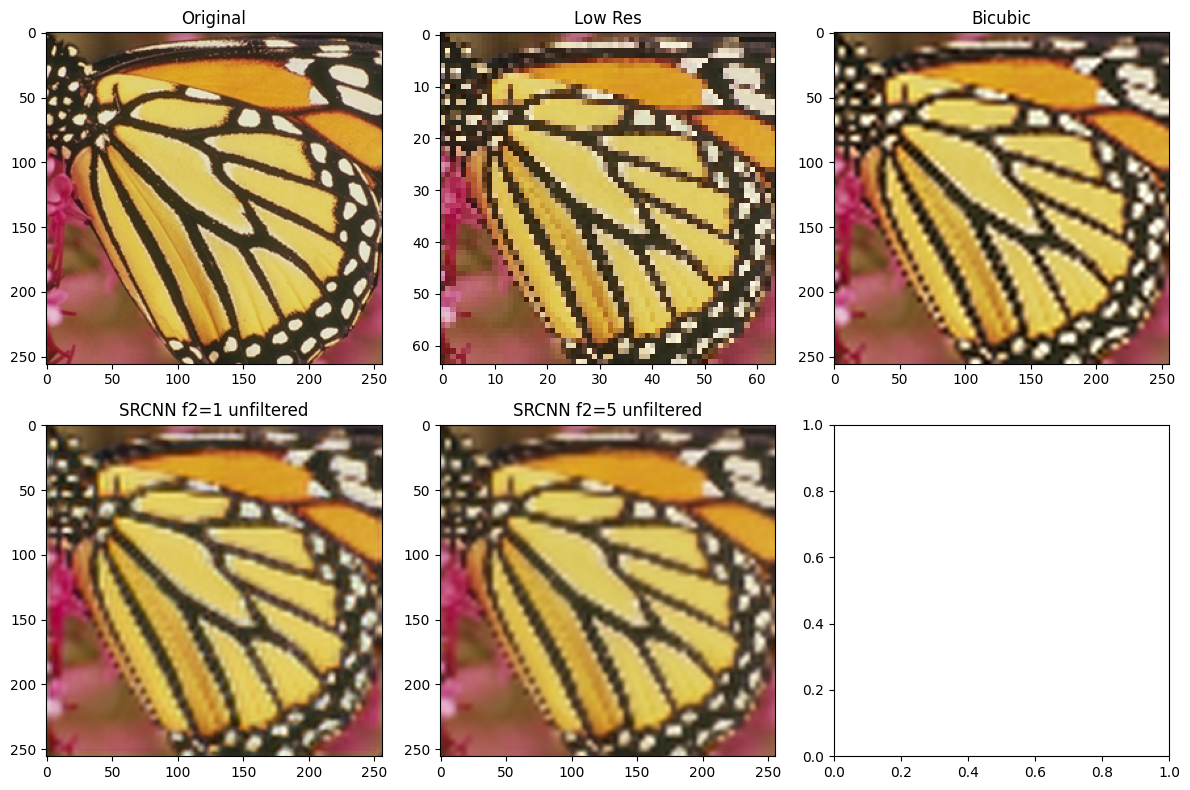

In [8]:
IMAGE_EXAMPLE = "./datasets/Set5/butterfly.png"

from image_helper import ImageHelper
image_helper = ImageHelper()

image_helper.show_tensors_custom_grid(
    tensors = [
        {
            "label": "Original",
            "tensor": image_helper.image_to_tensor(IMAGE_EXAMPLE),
        },
        {
            "label": "Low Res",
            "tensor": image_helper.downsample_image_as_tensor(
                IMAGE_EXAMPLE, 4, interpolation=Image.BICUBIC,
            ),
        },
        {
            "label": "Bicubic",
            "tensor": image_helper.downsample_and_upsample_image_as_tensor(
                IMAGE_EXAMPLE, 4
            ),
        },
        {
            "label": "SRCNN f2=1 unfiltered",
            "tensor": image_helper.apply_model_to_image(
                model_f2_1_test_unfiltered,
                IMAGE_EXAMPLE,
                4
            )
        },
        {
            "label": "SRCNN f2=5 unfiltered",
            "tensor": image_helper.apply_model_to_image(
                model_f2_5_test_unfiltered,
                IMAGE_EXAMPLE,
                4
            )
        },
    ],
    rows=2,
    cols=3,
    show_grid=True
)